# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from PIL import Image
import csv
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D , Reshape
from tensorflow.keras.backend import epsilon
from tensorflow.keras.applications import imagenet_utils

!pip install rarfile
import rarfile

drive.mount("/content/drive")

tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.3.0'

### Change directory

In [2]:
os.getcwd()
#os.pwd()

'/content'

### Load the training data from train.csv file

In [3]:
os.chdir("/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set")
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set'

### Print the shape of the train dataset

In [4]:
df_racoon = pd.read_csv("train_labels.csv")
df_racoon.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [5]:
IMAGE_SIZE = 128
FILE_PATH = []
batch_images = []

In [6]:
images_zip_file = 'images_racoon.rar'
folder_path =  '/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set/images'
mypath  = os.listdir('/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set/images')

with rarfile.RarFile(images_zip_file) as rf:
    rf.extractall()

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [7]:
for filename in mypath:
  FILE_PATH.append(filename)

In [8]:
FILE_PATH[8]

'raccoon-105.jpg'

In [9]:
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height


In [10]:
 i = 4
print(coords[i,0])
paths

27.194139194139193


['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg',
 'raccoon-82.jpg',
 'raccoon-4.jpg',
 'raccoon-101.jpg',
 'raccoon-10.jpg',
 'raccoon-166.jpg',
 'raccoon-184.jpg',
 'raccoon-38.jpg',
 'raccoon-120.jpg',
 'raccoon-142.jpg',
 'raccoon-149.jpg',
 'raccoon-51.jpg',
 'raccoon-43.jpg',
 'raccoon-123.jpg',
 'raccoon-66.jpg',
 'raccoon-9.jpg',
 'raccoon-178.jpg',
 'raccoon-47.jpg',
 'raccoon-167.jpg',
 'raccoon-54.jpg',
 'raccoon-77.jpg',
 'raccoon-155.jpg',
 'raccoon-89.jpg',
 'raccoon-153.jpg',
 'raccoon-179.jpg',
 'raccoon-115.jpg',
 'raccoon-64.jpg',
 'raccoon-56

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [11]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set'

In [12]:
for i, fil in enumerate(paths):
  #print(i, fil)
  img = Image.open('images/images/' + fil)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))


In [13]:
from google.colab.patches import cv2_imshow
import cv2

#img = cv2.imread('raccoon-152.jpg', cv2.IMREAD_UNCHANGED)
#cv2_imshow(img)


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [14]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False)

for layer in model.layers:
    layer.trainable = False

model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)


In [15]:
myModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [16]:
import tensorflow as tf

def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    #iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [17]:
myModel.compile(optimizer='Adam',loss='mse',metrics =[IoU])

In [18]:
myModel.fit(x = batch_images , y = coords , epochs= 30, verbose = 1 , batch_size = 32 )
            
#myModel.fit(batch_images, coords, epochs=30, batch_size = 32, workers=7, use_multiprocessing=True, shuffle=True, verbose=1) 

Epoch 1/30
6/6 [==============================] - 2s 312ms/step - loss: 3985.1746 - IoU: 0.0818
Epoch 2/30
6/6 [==============================] - 2s 313ms/step - loss: 737.2834 - IoU: 0.4372
Epoch 3/30
6/6 [==============================] - 2s 314ms/step - loss: 446.0309 - IoU: 0.5940
Epoch 4/30
6/6 [==============================] - 2s 314ms/step - loss: 621.8255 - IoU: 0.5278
Epoch 5/30
6/6 [==============================] - 2s 311ms/step - loss: 357.6801 - IoU: 0.6066
Epoch 6/30
6/6 [==============================] - 2s 311ms/step - loss: 197.5078 - IoU: 0.6541
Epoch 7/30
6/6 [==============================] - 2s 313ms/step - loss: 200.8911 - IoU: 0.6521
Epoch 8/30
6/6 [==============================] - 2s 315ms/step - loss: 161.5274 - IoU: 0.7039
Epoch 9/30
6/6 [==============================] - 2s 311ms/step - loss: 124.4747 - IoU: 0.7406
Epoch 10/30
6/6 [==============================] - 2s 314ms/step - loss: 113.9135 - IoU: 0.7639
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [23]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [49]:
print(batch_images.shape)

print(folder_path)
preprocessed_image = folder_path + '/images/' + 'raccoon-117.jpg'
print(preprocessed_image)

unscaled = cv2.imread(preprocessed_image)
preprocessed_image = cv2.imread(preprocessed_image)
image_height , image_width, channel = unscaled.shape
print(image_height)
print(image_width)
print(channel)

image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))


#preprocessed_image = prepare_image(preprocessed_image)

(173, 128, 128, 3)
/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set/images
/content/drive/My Drive/Colab Notebooks/GL AIML Lab & Project/ACV - Assignment/ACV Lab Questions and Data Set/images/images/raccoon-117.jpg
448
640
3


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [50]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

#predictions = myModel.predict(feat_scaled)[0] 
print(region)

[41.67927 24.00338 81.602   82.64027]


### Predict the coordinates of the bounding box for the given test image

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

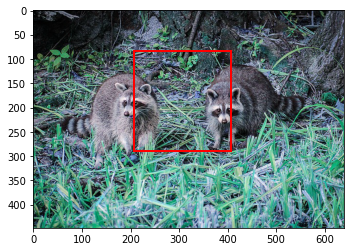

In [51]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()